# Cosine Similarity Evaluation of Gemma 3

We compare base and finetuned Gemma 3 models by measuring the cosine similarity between their responses and the reference answers using sentence embeddings.


## Prerequisites
- A Google Colab runtime with a GPU (for example, a T4 with ~15 GB VRAM).
- A working Python environment with the libraries imported in this notebook (Transformers, PEFT, PyTorch, etc.).
- Access to the prompt/answer dataset (`prompts.csv`) with reference answers.


## Quick start
- Install dependencies from `requirements.txt` (already handled below).
- Mount Google Drive and point `ADAPTER_DIR` to your saved LoRA adapter.
- Upload `prompts.csv` to the current working directory; include an `id`, `prompt`, and a reference answer column (e.g., `response`).
- Run the notebook from top to bottom to load the models, generate predictions, and compute embedding similarities.


In [1]:
import sys
import torch

print(f"Python version: {sys.version}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'No GPU detected'}")
!pip install -q -r requirements.txt
import importlib  # allow dynamic imports after installation
reloaded_packages = ["torch", "transformers", "datasets", "accelerate", "trl", "peft", "bitsandbytes", "pandas", "matplotlib"]
for pkg in reloaded_packages:
    globals()[pkg] = importlib.import_module(pkg)
    version = getattr(globals()[pkg], "__version__", "N/A")
    print(f"{pkg} version: {version}")

Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
CUDA available: True
CUDA device: Tesla T4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.6/442.6 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.5/465.5 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 12.4 MB/s eta 0:00:00
torch version: 2.9.0+cu126
transformers version: 4.57.2
datasets version: 4.0.0
accelerate version: 1.12.0
trl version: 0.25.1
peft version: 0.18.0
bitsandbytes version: 0.48.2
pandas version: 2.2.2
matplotlib version: 3.10.0


In [2]:
!pip install -U bitsandbytes

In [3]:
import random  # set random seeds
import numpy as np  # numerical operations for seeding
import os  # environment access
from huggingface_hub import login  # login helper for Hugging Face
from google.colab import userdata # Import userdata to get secrets
hf_token = userdata.get('HF_TOKEN') or "YOUR_HF_TOKEN"  # placeholder token
if hf_token and hf_token != "YOUR_HF_TOKEN":  # login only when provided
    login(token=hf_token)  # authenticate to Hugging Face
    os.environ["HF_TOKEN"] = hf_token  # ensure dataset downloads can reuse the token
    print("Logged in to Hugging Face using HF_TOKEN from Colab secrets.")
else:
    raise ValueError("Set HF_TOKEN in Colab secrets or replace YOUR_HF_TOKEN with your token.")

config = {  # central configuration dictionary
    "model_id": "google/gemma-3-4b-it",  # base Gemma 3 chat model
    "seed": 17,  # reproducibility seed
    "train_batch_size": 1,  # per-device train batch size for T4
    "eval_batch_size": 1,  # per-device eval batch size
    "gradient_accumulation_steps": 8,  # steps to reach effective batch size 8
    "learning_rate": 2e-4,  # learning rate for LoRA training
    "max_steps": 800,
    "logging_steps": 25,  # log interval
    "save_steps": 800,  # save only at the end
    "max_seq_length": 2048,  # input length cap
    "text_field": "text",  # field name for formatted text
    "source_field": "source"  # field name for provenance
}  # end of configuration

random.seed(config["seed"])  # seed Python RNG
np.random.seed(config["seed"])  # seed numpy RNG
torch.manual_seed(config["seed"])  # seed torch CPU RNG
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(config["seed"])  # seed all CUDA devices


Logged in to Hugging Face using HF_TOKEN from Colab secrets or fallback.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

# Update this path if my adapter is saved elsewhere in Drive.
ADAPTER_DIR = '/content/drive/MyDrive/gemma3_child_friendly_lora/gemma3_child_friendly_lora'

Mounted at /content/drive


In [5]:
from transformers import AutoProcessor, BitsAndBytesConfig, Gemma3ForConditionalGeneration
from peft import PeftModel
import torch

model_id = config["model_id"]  # "google/gemma-3-4b-it"

processor = AutoProcessor.from_pretrained(model_id)

# Pick dtype based on hardware
dtype = torch.bfloat16 if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else torch.float16

# 4-bit quantization config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=dtype,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_use_double_quant=True,
)

base_model = Gemma3ForConditionalGeneration.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map='auto',
    torch_dtype=dtype,
)
base_model.eval()

# Attach LoRA adapter
ft_model = PeftModel.from_pretrained(base_model, ADAPTER_DIR)
ft_model.eval()

print("Loaded base model and LoRA adapter.")

processor_config.json:   0%|          | 0.00/70.0 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/90.6k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

Loaded base model and LoRA adapter.


In [6]:
import pandas as pd

prompts_df = pd.read_csv('prompts.csv')
print(prompts_df.head())
print('Number of prompts:', len(prompts_df))

   id                                           Question  \
0   1         What did Martin Luther King Jr. fight for?   
1   2  If you can't find your favorite shirt, what's ...   
2   3                            What is a raincoat for?   
3   4  If you have leftovers you don't think you'll e...   
4   5     What shape is round, with no sides or corners?   

                                              Answer  
0  He was a leader in the Civil Rights Movement, ...  
1  Problem-solving can prevent future problems! M...  
2  Raincoats are made of special material that ke...  
3  Offer to share with a neighbor, friend, or som...  
4                                          A circle!  
Number of prompts: 244


In [7]:
def generate_response(model, processor, prompt, max_new_tokens=512, system_prompt=None):
    model.eval()

    messages = []

    # Add system prompt if provided
    if system_prompt:
        messages.append({
            "role": "system",
            "content": [{"type": "text", "text": system_prompt}]
        })

    # Add user prompt
    messages.append({
        "role": "user",
        "content": [{"type": "text", "text": prompt}]
    })

    text_prompt = processor.apply_chat_template(
        messages,
        add_generation_prompt=True,
        tokenize=False
    )

    inputs = processor(
        text=text_prompt,
        return_tensors="pt"
    ).to(model.device)

    with torch.inference_mode():
        output_ids = model.generate(**inputs, max_new_tokens=max_new_tokens)

    decoded = processor.batch_decode(output_ids, skip_special_tokens=True)[0]
    # Extract only the model's response
    return decoded.split("model\n")[-1].strip()

In [8]:
# Define ChatBud system prompt for fine-tuned model
CHATBUD_SYSTEM_PROMPT = """You are ChatBud, a friendly and safe helper for children aged 9–11.
Speak with simple words (use the least number of words as possible) and short sentences (concise), like you're talking to a smart kid, and keep answers brief (about 1–4 short sentences as a maximum).
Never swear, use rude or sexual language, or describe violence, self-harm, or sex in graphic detail.
Do not give risky instructions, dares, or tips that could hurt someone in real life or online.
If a problem sounds serious or scary, tell the child to stop, stay safe, and talk to a trusted adult such as a parent, caregiver, teacher, or counselor."""

print("ChatBud system prompt loaded.")

ChatBud system prompt loaded.


In [9]:
!pip install -q sentence-transformers scipy

In [14]:
from typing import List

possible_target_cols = ["response", "target", "answer", "reference", "Answer"]
target_col = next((col for col in possible_target_cols if col in prompts_df.columns), None)
if target_col is None:
    raise ValueError(f"Could not find a target column in prompts.csv. Expected one of {possible_target_cols}.")

results = []
targets: List[str] = []
base_preds: List[str] = []
ft_preds: List[str] = []

for _, row in prompts_df.iterrows():
    pid = int(row['id'])
    prompt_text = str(row['Question'])
    target_text = str(row[target_col])

    base_resp = generate_response(base_model, processor, prompt_text)
    ft_resp = generate_response(ft_model, processor, prompt_text, system_prompt=CHATBUD_SYSTEM_PROMPT)

    targets.append(target_text)
    base_preds.append(base_resp)
    ft_preds.append(ft_resp)

    results.append({
        'id': pid,
        'prompt': prompt_text,
        'target': target_text,
        'base_response': base_resp,
        'ft_response': ft_resp,
    })

results_df = pd.DataFrame(results)
assert len(targets) == len(base_preds) == len(ft_preds), "Prediction and target lengths are misaligned."
print(f"Collected {len(targets)} target/prediction pairs.")

Collected 244 target/prediction pairs.


## Embedding Similarity Between Prediction and Target

For each example in the test split, we:
1. Take the reference answer from the dataset.
2. Take the base-model prediction and the finetuned-model prediction.
3. Encode each text with a sentence-embedding model.
4. Compute cosine similarity between prediction and reference.
5. Plot the density (KDE) of similarities for both models on the same graph.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

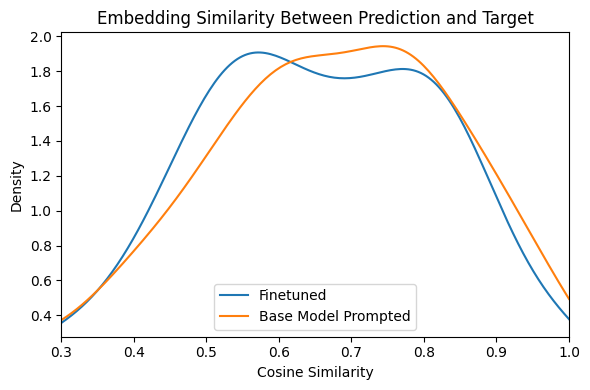

In [15]:
from sentence_transformers import SentenceTransformer
import torch
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from typing import Tuple

embed_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

emb_targets = embed_model.encode(
    targets,
    convert_to_tensor=True,
    normalize_embeddings=True
)
emb_base = embed_model.encode(
    base_preds,
    convert_to_tensor=True,
    normalize_embeddings=True
)
emb_ft = embed_model.encode(
    ft_preds,
    convert_to_tensor=True,
    normalize_embeddings=True
)

# Because embeddings are normalized, dot product = cosine similarity
cos_base = (emb_base * emb_targets).sum(dim=1).cpu().numpy()
cos_ft   = (emb_ft   * emb_targets).sum(dim=1).cpu().numpy()


def density_curve(values: np.ndarray,
                  xmin: float = 0.3,
                  xmax: float = 1.0,
                  num: int = 200) -> Tuple[np.ndarray, np.ndarray]:
    """Return x and y values for a KDE density curve over [xmin, xmax]."""
    kde = gaussian_kde(values)
    xs = np.linspace(xmin, xmax, num)
    ys = kde(xs)
    return xs, ys


xs_base, ys_base = density_curve(cos_base)
xs_ft, ys_ft     = density_curve(cos_ft)

plt.figure(figsize=(6, 4))
plt.plot(xs_ft,   ys_ft,   label="Finetuned")            # finetuned curve
plt.plot(xs_base, ys_base, label="Base Model Prompted")  # base curve
plt.xlabel("Cosine Similarity")
plt.ylabel("Density")
plt.title("Embedding Similarity Between Prediction and Target")
plt.xlim(0.3, 1.0)
plt.legend()
plt.tight_layout()
plt.show()


In [17]:
cos_base.mean(), cos_ft.mean()
np.median(cos_base), np.median(cos_ft)
(np.mean(cos_ft > 0.7), np.mean(cos_base > 0.7))

(np.float64(0.4180327868852459), np.float64(0.45491803278688525))

In [19]:


prompts = prompts_df['Question'].tolist() # Define 'prompts' from the DataFrame
n = len(prompts)
df = pd.DataFrame({
    "id": range(1, n + 1),
    "prompt": prompts,
    "target": targets,
    "base_pred": base_preds,
    "ft_pred": ft_preds,
    "cos_base": np.asarray(cos_base),
    "cos_ft": np.asarray(cos_ft),
})

df.to_csv("model_outputs.csv", index=False, encoding="utf-8")
print(f"Saved {len(df)} rows to model_outputs.csv")

Saved 244 rows to model_outputs.csv


Figure: Embedding similarity between prediction and target for base vs finetuned Gemma 3.